**Requirements:**
1. Our data 'stringer_spontaneous.npy' should be in the same folder with this .ipynb file
2. numpy & matplotlib & sklearn should be installed in your local computer

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#@title Data loading
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

### Dimensionality Reduction by PCA

In [11]:
neuron_data = dat['sresp'].T  # 7018*11983, type is np.ndarray

What need to be reduced is the number of neurons, not the number of timebins, so input data should be the transpose of dat['sresp'].

#### Figure Out Which K to Choose

In [12]:
X = neuron_data - neuron_data.mean(axis=0)

In [13]:
cov_matrix = (X.T@X) / X.shape[0]

In [15]:
evals, evectors = np.linalg.eigh(cov_matrix)

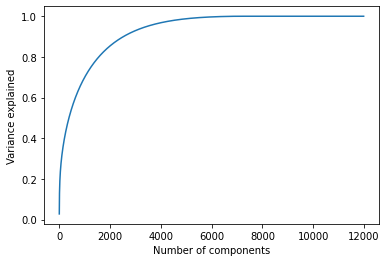

In [17]:
# plot variance explained curve
index = np.flip(np.argsort(evals))
explained_sum = np.cumsum(evals[index])
explained_sum_ratio = explained_sum / explained_sum.max()

plt.figure()
plt.plot(np.arange(1, len(explained_sum_ratio) + 1), explained_sum_ratio)
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.show()

In [19]:
# select the first K whose corresponding variance explained >= variance_explained_threshold
variance_explained_threshold = 0.9
k_explain = np.argwhere(explained_sum_ratio>=variance_explained_threshold)
k_chosen = k_explain[0][0]
print('k_chosen:', k_chosen)

k_chosen: 2525


#### Dimensionality Reduction Using k_chosen Components

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k_chosen)
neuron_data_reduced = pca.fit_transform(neuron_data)
components = pca.components_  # the weights (new basis)

In [21]:
print('The shape of the reduced data is:', neuron_data_reduced.shape)
print('The shape of the k_chosen components is:', components.shape)

The shape of the reduced data is: (7018, 2525)
The shape of the k_chosen components is: (2525, 11983)


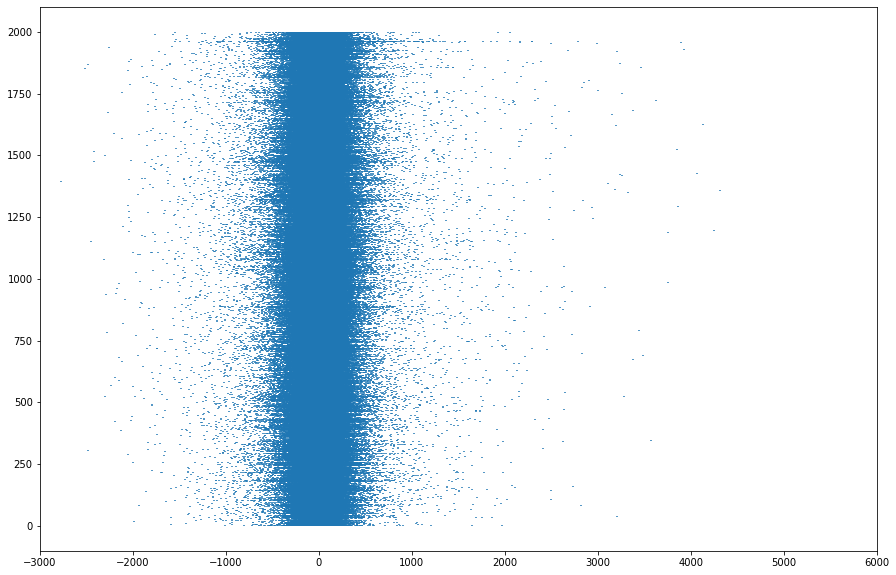

In [23]:
idx = np.arange(len(neuron_data_reduced))
np.random.shuffle(idx)

plt.figure(figsize=(15,10))
plt.eventplot(neuron_data_reduced[:2000])
plt.xlim((-3000,6000))
plt.show()

We can now use *neuron_data_reduced* $(7018*2525)$ to do further analysis.

### Use Linear Regression to Predict Running Speed

#### split the dataset into training set and testing set

In [62]:
X = neuron_data_reduced
y = dat['run']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Number of data samples in X_train:', len(X_train))
print('Number of data samples in X_test:', len(X_test))

Number of data samples in X_train: 4912
Number of data samples in X_test: 2106


#### use training set to fit lasso model and test prediction performance on testing set

In [63]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred, y_test))

Prediction MSE: 18.873632799808938


#### use all data to fit lasso model and plot the actual and predicted plot of running speed

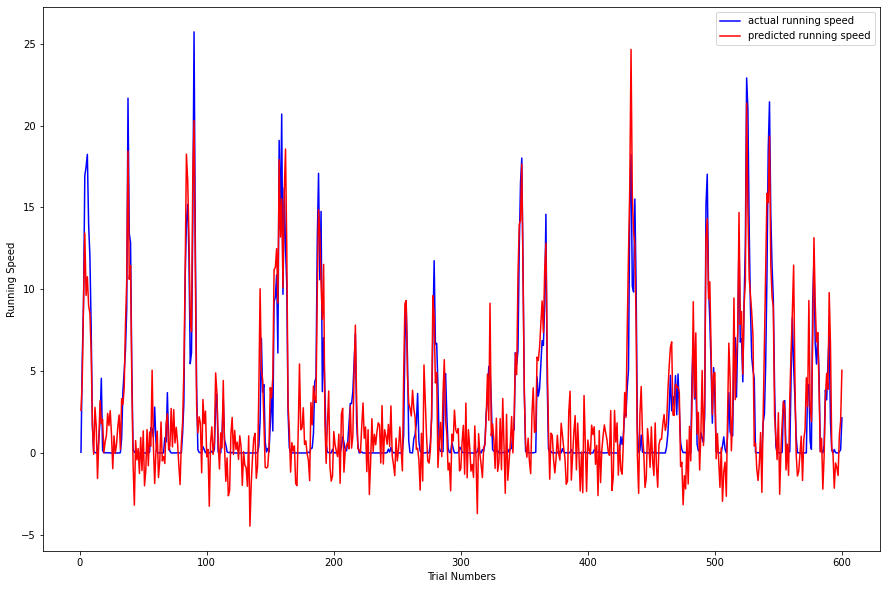

In [64]:
lasso_all = linear_model.Lasso(alpha=0.1)
lasso_all.fit(X, y)
y_pred = lasso_all.predict(X)

# plot the first n actual and predicted data points
n = 600
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y[:n])+1), y[:n], 'b-', label='actual running speed')
plt.plot(range(1,len(y_pred[:n])+1), y_pred[:n], 'r-', label='predicted running speed')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Running Speed')
plt.show()

### Use Linear Regression to Predict Pupil Area

#### use training set to fit lasso model and test prediction performance on testing set

In [65]:
X = neuron_data_reduced
y = dat['pupilArea']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Number of data samples in X_train:', len(X_train))
print('Number of data samples in X_test:', len(X_test))

Number of data samples in X_train: 4912
Number of data samples in X_test: 2106


#### use training set to fit lasso model and test prediction performance on testing set

In [66]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred, y_test))

Prediction MSE: 27902.092705749634


#### use all data to fit lasso model and plot the actual and predicted plot of running speed

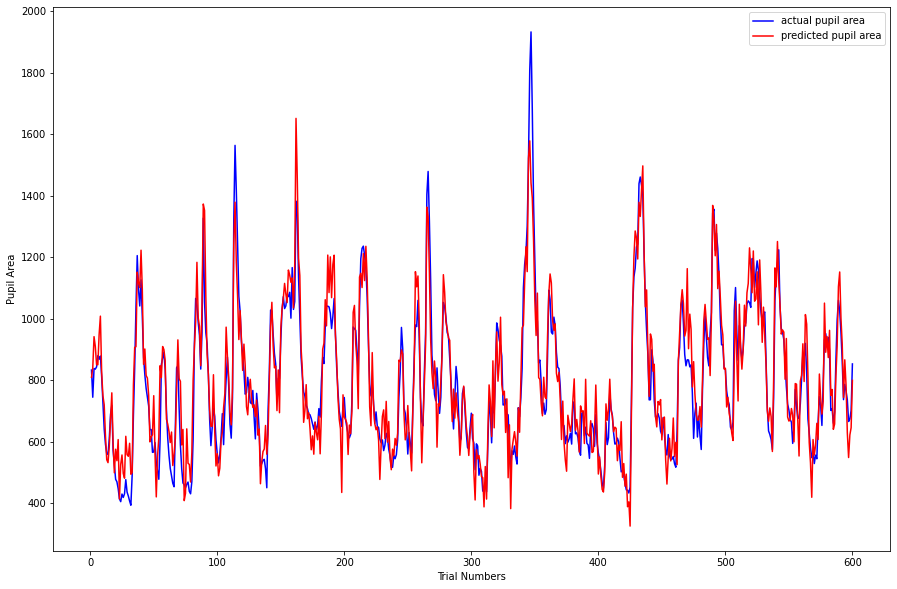

In [67]:
lasso_all = linear_model.Lasso(alpha=0.1)
lasso_all.fit(X, y)
y_pred = lasso_all.predict(X)

# plot the first n actual and predicted data points
n = 600
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y[:n])+1), y[:n], 'b-', label='actual pupil area')
plt.plot(range(1,len(y_pred[:n])+1), y_pred[:n], 'r-', label='predicted pupil area')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Pupil Area')
plt.show()